In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from matplotlib import cm
from iminuit import Minuit
from sklearn.linear_model import LinearRegression

In [2]:
sns.set_context('talk')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (8, 8)

In [3]:
fig_dir = os.path.abspath('./figures')

# Multicollinearity

Multicollinearity in regression refers to a situation in which two or more covariates are strongly correlated. In order to discuss some results of this situation, consider the following toy model.

A series of $n$ observations $\{(x_1^{(1)}, x_2^{(1)}), \cdots, (x_1^{(n)}, x_2^{(n)})\}$ is drawn from a two-dimensional Gaussian distribution with $\mu=(0, 0)$ and a covariance matrix given by
$$\Sigma = \left(\begin{matrix}
\sigma_{1}^2 & \rho\sigma_1\sigma_2\\
\rho\sigma_1\sigma_2 & \sigma_2^2\end{matrix}\right)$$

We also have
$$y=\beta_1 x_1 + \beta_2 x_2 + \epsilon_{int}$$
where $\epsilon_{int}$ is a noise vector drawn from the univariate normal distribution $\mathcal{N}(0, \sigma_{int})$.

In [4]:
def generate_fake_data(b1, b2, cov, sig_int, n):
    X = np.random.multivariate_normal([0, 0], cov, n)
    epsilon = sig_int * np.random.randn(len(X))
    y = b1 * X[:, 0] + b2 * X[:, 1] + epsilon
    return epsilon, X, y

In [5]:
b1, b2 = 0.3, -0.5
sig1 = 0.4
sig2 = 1.5
rho = 0.5
sig_int = 0.3
n = 10000
cov = np.array([[sig1**2, rho*sig1*sig2], [rho*sig1*sig2, sig2**2]])

eps, X, y = generate_fake_data(b1, b2, cov, sig_int, n)

Text(0, 0.5, '$y$')

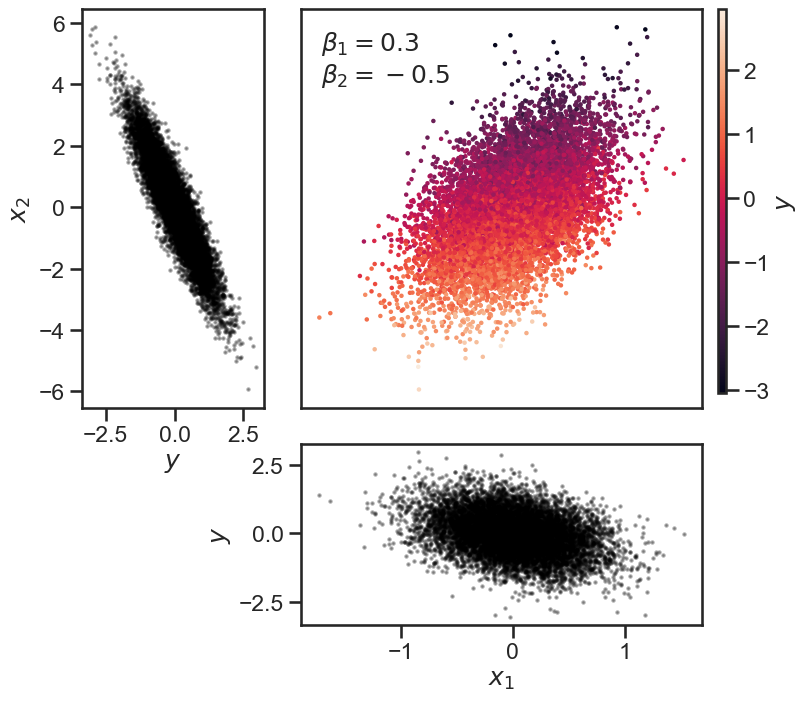

In [6]:
plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((3, 3), (0, 1), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3, 3), (0, 0), rowspan=2)
ax3 = plt.subplot2grid((3, 3), (2, 1), colspan=2)
cb_ax = plt.gcf().add_axes([0.92, 0.4, 0.01, 0.48])

scatter_x = ax1.scatter(*X.T, c=y, s=3)
cbar = plt.colorbar(scatter_x, cax=cb_ax, label='$y$')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.text(0.05, 0.95,
         '$\\beta_1 = {:0.1f}$\n$\\beta_2 = {:0.1f}$'.format(b1, b2),
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax1.transAxes,
         )
ax2.scatter(y, X[:, 1], color='k', s=3, alpha=0.3)
ax2.set_xlabel('$y$')
ax2.set_ylabel('$x_2$')
ax3.scatter(X[:, 0], y, color='k', s=3, alpha=0.3)
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$y$')

# path = os.path.join(fig_dir, 'example_linear_scatter.pdf')
# plt.savefig(path, bbox_inches='tight')

The marginal distributions of $x_1$ and $x_2$ are also normal, with standard deviations given by. $\sigma_1$ and $\sigma_2$ respectively. $y$ is also normally distributed with $\text{var}(y)=\beta_1^2\sigma_1^2 + \beta_2^2\sigma_2^2 + 2\beta_1\beta_2\rho\sigma_1\sigma_2 + \sigma_{int}^2$

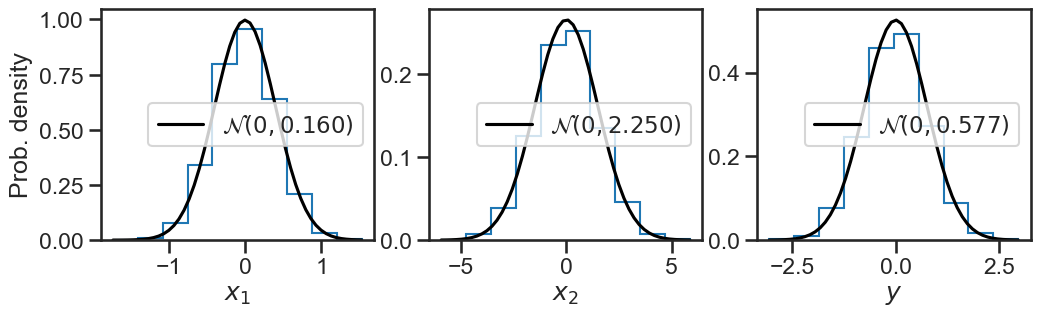

In [7]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
linx = np.linspace(X[:, 0].min(), X[:, 0].max())
plt.plot(linx, stats.norm.pdf(linx, scale=sig1),
         color='k', label='$\mathcal{{N}}(0, {:0.3f})$'.format(sig1**2))
plt.hist(X[:, 0], density=True, histtype='step', color='C0')
plt.xlabel('$x_1$')
plt.ylabel('Prob. density')
plt.legend()

plt.subplot(132)
linx = np.linspace(X[:, 1].min(), X[:, 1].max())
plt.plot(linx, stats.norm.pdf(linx, scale=sig2),
         color='k', label='$\mathcal{{N}}(0, {:0.3f})$'.format(sig2**2))
plt.hist(X[:, 1], density=True, histtype='step', color='C0')
plt.xlabel('$x_2$')
plt.legend()

plt.subplot(133)
linx = np.linspace(y.min(), y.max())
sigy = b1**2*sig1**2 + b2**2 * sig2**2 + 2*b1*b2*rho*sig1*sig2 + sig_int**2
plt.plot(linx, stats.norm.pdf(linx, scale=np.sqrt(sigy)),
         color='k', label='$\mathcal{{N}}(0, {:0.3f})$'.format(sigy))
plt.hist(y, density=True, histtype='step', color='C0')
plt.xlabel('$y$')
plt.legend()


## Simultaneous linear regression

Doing typical linear regression, we expect to recover the regression coefficients ($\alpha$ and $\beta$) and we expect to be able to reconstruct $y$ with our model with only the noise left over.

In [8]:
lin_model = LinearRegression()
lin_model.fit(X, y)
resid = y - lin_model.predict(X)

In [9]:
print('True regression coefs:     {:0.3f}, {:0.3f}'.format(b1, b2))
print('Best-fit regression coefs: {:0.3f}, {:0.3f}'.format(*lin_model.coef_))

True regression coefs:     0.300, -0.500
Best-fit regression coefs: 0.311, -0.504


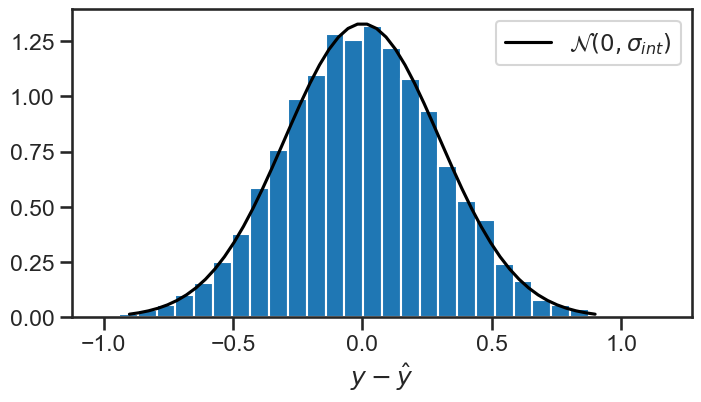

In [10]:
plt.figure(figsize=(8, 4))
plt.hist(resid, bins=30, density=True)
plt.xlabel('$y-\hat{y}$')
linx = np.linspace(-3*sig_int, 3*sig_int)
plt.plot(linx,
         stats.norm(scale=sig_int).pdf(linx),
         color='k',
         label='$\mathcal{N}(0, \sigma_{int})$')
plt.legend()

Let's repeat this experiment for several trials with varying values of $\Sigma_{12}$ to see how this relates to the error on the recovered coefficients $\alpha$ and $\beta$ (we denote these recovered coefficients as $\hat{\alpha}$ and $\hat{\beta}$)

In [11]:
def repeat_analysis(a, b, sig1, sig2, sig_int,
                    n, n_corr_bins, trials_per_corr_bin):
    trials = {}
    corrs = np.linspace(-0.9999, 0.9999, n_corr_bins)
    for corr in corrs:
        cov = [[sig1**2, corr*sig1*sig2], [corr*sig1*sig2, sig2**2]]
        corr_trials = {}
        for i in range(trials_per_corr_bin):
            epsilon, X, y = generate_fake_data(a, b, cov, sig_int, n)
            lin_model = LinearRegression()
            lin_model.fit(X, y)
            resid = y - lin_model.predict(X)
            corr_trials[i] = {'fit_b1': lin_model.coef_[0],
                              'fit_b2': lin_model.coef_[1],
                              'std_eps': np.std(epsilon),
                              'std_resid': np.std(resid)}
        mean_fit_b1 = np.mean([t['fit_b1'] for t in corr_trials.values()])
        mean_fit_b2 = np.mean([t['fit_b2'] for t in corr_trials.values()])
        std_fit_b1 = np.std([t['fit_b1'] for t in corr_trials.values()])
        std_fit_b2 = np.std([t['fit_b2'] for t in corr_trials.values()])
        trials[corr] = {'mean_fit_b1': mean_fit_b1,
                        'mean_fit_b2': mean_fit_b2,
                        'std_fit_b1': std_fit_b1,
                        'std_fit_b2': std_fit_b2}
    trials = pd.DataFrame(trials).T
    trials['corr_coef'] = trials.index
    return trials

In [12]:
b1, b2 = 0.3, -0.7
sig1 = 1
sig2 = np.sqrt(2)
sig_int = 0.3
N = 100
M = 100
trials = repeat_analysis(b1, b2, sig1, sig2, sig_int, N, M, 100)

In [13]:
trials.head()

,mean_fit_b1,mean_fit_b2,std_fit_b1,std_fit_b2,corr_coef
-0.9999,0.560702,-0.514839,2.313949,1.639503,-0.9999
-0.9797,0.291847,-0.701659,0.138511,0.102775,-0.9797
-0.9595,0.310059,-0.692265,0.094343,0.069672,-0.9595
-0.9393,0.300304,-0.696671,0.092684,0.064908,-0.9393
-0.9191,0.302749,-0.698878,0.077426,0.054546,-0.9191


Text(0.5, 0, '$\\Sigma_{12}$')

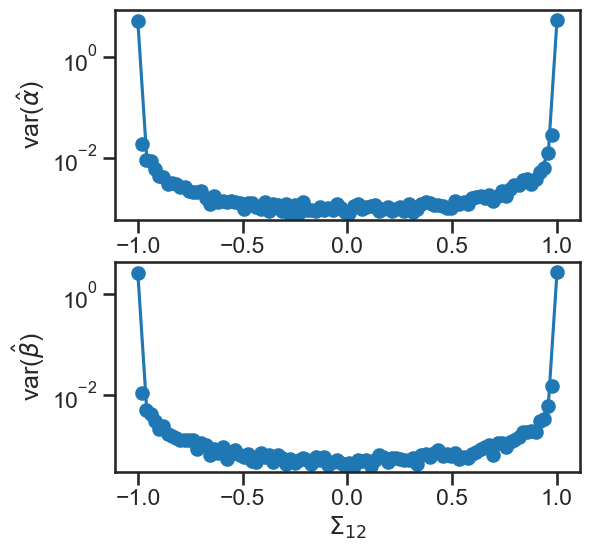

In [14]:
plt.figure(figsize=(6, 6))
plt.subplot(211)
plt.scatter(trials.corr_coef, trials.std_fit_b1**2)
linx = np.linspace(trials.corr_coef.min(), trials.corr_coef.max())
plt.plot(linx, sig_int**2/(N*sig1**2*(1-linx**2)))
plt.yscale('log')
plt.ylabel('var($\hat{\\alpha}$)')
plt.subplot(212)
plt.scatter(trials.corr_coef, trials.std_fit_b2**2)
linx = np.linspace(trials.corr_coef.min(), trials.corr_coef.max())
plt.plot(linx, sig_int**2/(N*sig2**2*(1-linx**2)))
plt.yscale('log')
plt.ylabel('var($\hat{\\beta}$)')
plt.xlabel('$\Sigma_{12}$')

$$\sigma_{\hat{\beta_0}}^2=\frac{\sigma_{int}^2}{N\sigma_1^2\left(1-\rho^2\right)}$$

$$\sigma_{\hat{\beta}}^2=\frac{\sigma_{int}^2}{N\sigma_2^2\left(1-\rho^2\right)}$$

## Linear regression component by component


First, let's see what happens in the uncorrelated case. We'll start by generating fake data:

In [15]:
b1, b2 = 0.1, 0.9
sig1 = np.sqrt(1)
sig2 = np.sqrt(2)
rho = 0.
sig_int = 0.3
n = 10000
cov = np.array([[sig1**2, rho*sig1*sig2], [rho*sig1*sig2, sig2**2]])

eps, X, y = generate_fake_data(b1, b2, cov, sig_int, n)

Then fit the true two-dimensional regression:

In [16]:
lin_model = LinearRegression()
lin_model.fit(X, y)
resid = y - lin_model.predict(X)

And then the two step regression.

In [17]:
lin_b1 = LinearRegression()
lin_b1.fit(X[:, 0].reshape(-1, 1), y)
r_b1 = y - lin_b1.predict(X[:, 0].reshape(-1, 1))
lin_b2 = LinearRegression()
lin_b2.fit(X[:, 1].reshape(-1, 1), r_b1)
r_b2 = r_b1 - lin_b2.predict(X[:, 1].reshape(-1, 1))

We'll then compare the fit coefficients and the residuals.

In [18]:
print('True alpha: {:0.3f}'.format(b1))
print('2D alpha: {:0.3f}'.format(lin_model.coef_[0]))
print('1D alpha: {:0.3f}'.format(lin_b1.coef_[0]))
print()
print('True beta: {:0.3f}'.format(b2))
print('2D beta: {:0.3f}'.format(lin_model.coef_[1]))
print('1D beta: {:0.3f}'.format(lin_b2.coef_[0]))

True alpha: 0.100
2D alpha: 0.107
1D alpha: 0.116

True beta: 0.900
2D beta: 0.899
1D beta: 0.899


Text(0.5, 0, 'Residual')

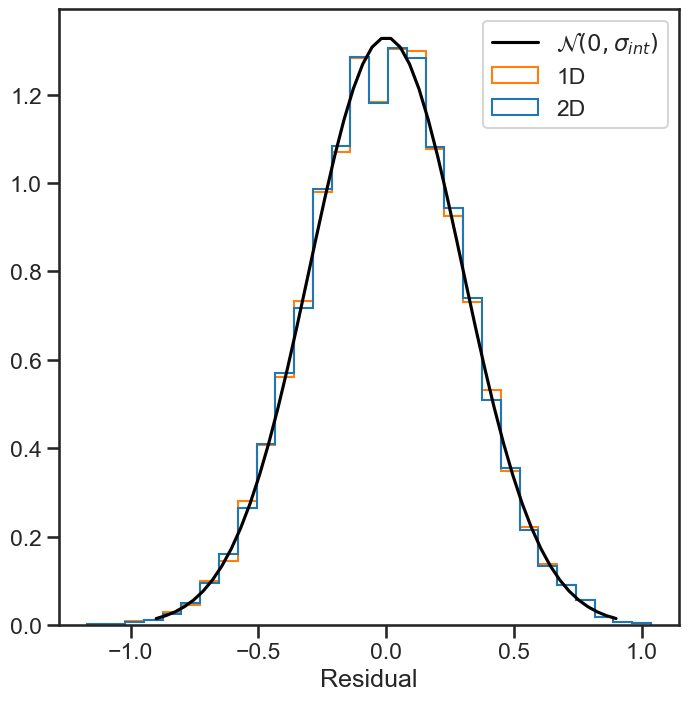

In [19]:
plt.hist([resid, r_b2], label=['2D', '1D'], density=True, bins=30, histtype='step')
linx = np.linspace(-3*sig_int, 3*sig_int)
plt.plot(linx,
         stats.norm(scale=sig_int).pdf(linx),
         color='k',
         label='$\mathcal{N}(0, \sigma_{int})$')
plt.legend()
plt.xlabel('Residual')

Without any off-diagonal elements in the covariance matrix, we recover the regression coefficients and the scatter on the residuals remains the same.

Now we'll repeat this with some covariance.

In [20]:
b1, b2 = 0.1, 0.9
sig1 = 1
sig2 = np.sqrt(2)
rho = 0.5
sig_int = 0.3
n = 10000
cov = np.array([[sig1**2, rho*sig1*sig2], [rho*sig1*sig2, sig2**2]])

eps, X, y = generate_fake_data(b1, b2, cov, sig_int, n)

In [21]:
lin_model = LinearRegression()
lin_model.fit(X, y)
resid = y - lin_model.predict(X)
lin_b1 = LinearRegression()
lin_b1.fit(X[:, 0].reshape(-1, 1), y)
r_b1 = y - lin_b1.predict(X[:, 0].reshape(-1, 1))
lin_b2 = LinearRegression()
lin_b2.fit(X[:, 1].reshape(-1, 1), r_b1)
r_b2 = r_b1 - lin_b2.predict(X[:, 1].reshape(-1, 1))

In [22]:
print('True alpha: {:0.3f}'.format(b1))
print('2D alpha: {:0.3f}'.format(lin_model.coef_[0]))
print('1D alpha: {:0.3f}'.format(lin_b1.coef_[0]))
print()
print('True beta: {:0.3f}'.format(b2))
print('2D beta: {:0.3f}'.format(lin_model.coef_[1]))
print('1D beta: {:0.3f}'.format(lin_b2.coef_[0]))

True alpha: 0.100
2D alpha: 0.096
1D alpha: 0.710

True beta: 0.900
2D beta: 0.899
1D beta: 0.687


Text(0.5, 0, 'Residual')

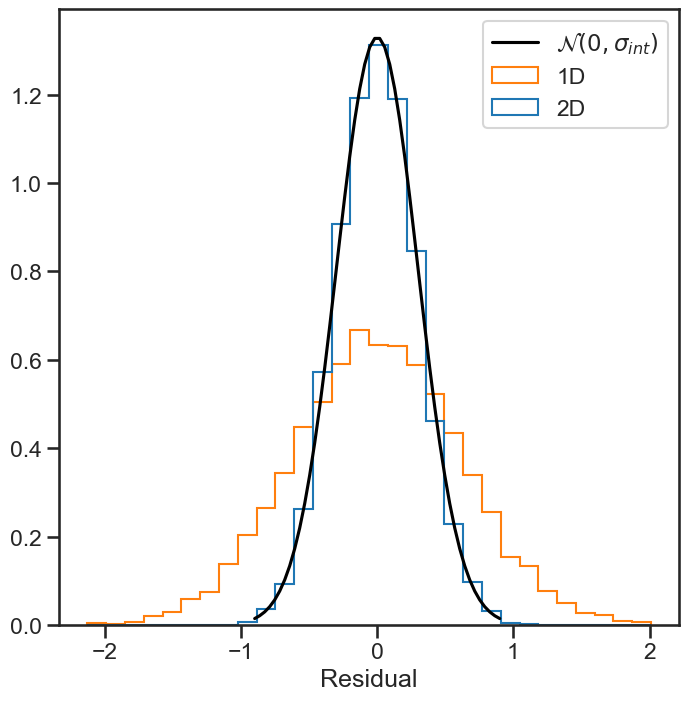

In [23]:
plt.hist([resid, r_b2], label=['2D', '1D'], density=True, bins=30, histtype='step')
linx = np.linspace(-3*sig_int, 3*sig_int)
plt.plot(linx,
         stats.norm(scale=sig_int).pdf(linx),
         color='k',
         label='$\mathcal{N}(0, \sigma_{int})$')
plt.legend()
plt.xlabel('Residual')

$\hat{\beta_1}^\prime$ and $\hat{\beta_2}^\prime$ are very far off the true values, and the scale of the residuals has changed significantly.

We'll run another series of trials to see how the bias is related to the size of the covariance and the scale of the coefficients relating $X$ and $y$. We'll also see how the scale of the residuals change.

In [24]:
def do_analysis(corr, sig_int, sig1, sig2):
    def func(X):
        b1, b2 = np.random.rand(2) * 2 - 1
        epsilon = sig_int * np.random.randn(len(X))
        return b1, b2, epsilon, b1 * X[:, 0] + b2 * X[:, 1] + epsilon
    
    cov = [[sig1**2, corr*sig1*sig2], [corr*sig1*sig2, sig2**2]]
    X = np.random.multivariate_normal([0, 0], cov, 1000)
    b1, b2, eps, y = func(X)
    
    lin = LinearRegression()
    lin.fit(X, y)
    resid = y - lin.predict(X)
    
    lin_b1 = LinearRegression()
    lin_b1.fit(X[:, 0].reshape(-1, 1), y)
    r_b1 = y - lin_b1.predict(X[:, 0].reshape(-1, 1))
    lin_b2 = LinearRegression()
    lin_b2.fit(X[:, 1].reshape(-1, 1), r_b1)
    r_b2 = r_b1 - lin_b2.predict(X[:, 1].reshape(-1, 1))
    
    truth = [b1, b2, eps]
    models = [lin, lin_b1, lin_b2]
    resids = [resid, r_b1, r_b2]

    return truth, models, resids

In [25]:
df = {}
sig1 = np.sqrt(3.)
sig2 = np.sqrt(4.5)
sig_int = 0.3
for corr in tqdm(np.arange(-1, 1, 0.0005)):
    truth, models, resids = do_analysis(corr, sig_int, sig1, sig2)
    b1, b2, eps = truth
    df[corr] = {'b1': b1,
                'b2': b2,
                'fit_b1': models[0].coef_[0],
                'fit_b2': models[0].coef_[1],
                'fit1_b1': models[1].coef_[0],
                'fit12_b2': models[2].coef_[0],
                'std_eps': np.std(eps),
                'std_resid': np.std(resids[0]),
                'std_resid1': np.std(resids[1]),
                'std_resid12': np.std(resids[2])}
df = pd.DataFrame(df).T
df['corr_coef'] = df.index

100%|██████████| 4000/4000 [00:07<00:00, 521.32it/s]


First we'll look at the size of the bias in the first coefficient, i.e. $\Delta\beta_1=\beta_1 - \hat{\beta_1}^\prime$.

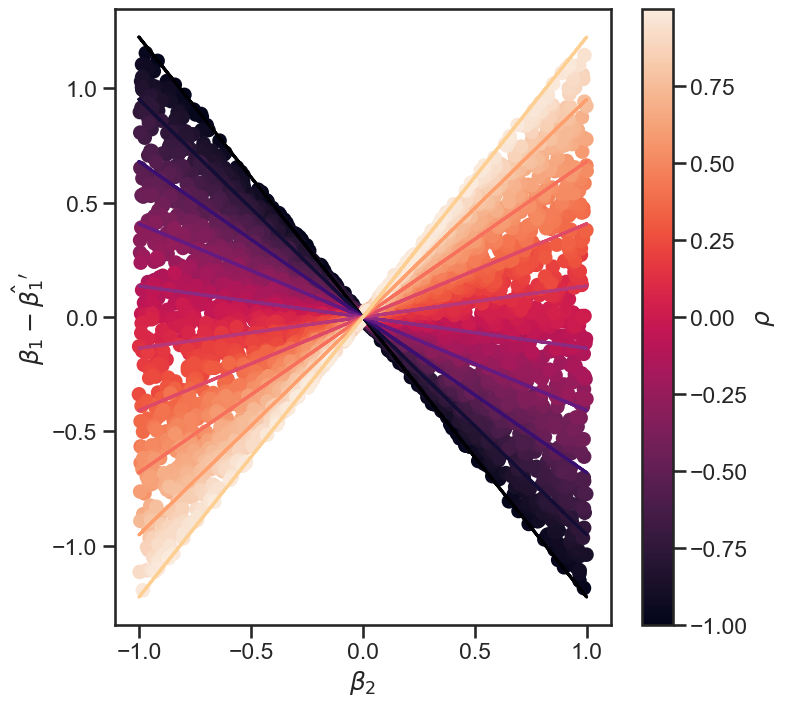

In [26]:
plt.scatter(df.b2, df.fit1_b1-df.b1, c=df.corr_coef)
for i, rho in enumerate(np.linspace(-1, 1, 10)):
    plt.plot(df.b2, df.b2*rho*sig2/sig1, color=cm.magma(i/10))
plt.xlabel('$\\beta_2$')
plt.ylabel('$\\beta_1 - \hat{\\beta_1}^\prime$')
plt.colorbar(label='$\\rho$')

This shows us that the bias on the first coefficient is
$$\Delta\beta_1 = \frac{\beta_2\rho\sigma_2}{\sigma_1}$$

With this, we can easily calculate the expected residuals from the first fit:

$$r_{\beta_1} = \beta_1 x_1 + \beta_2 x_2 - \hat{\beta_1}^\prime x_1 = -\frac{\beta_2\rho\sigma_2}{\sigma_1}x_1 + \beta_2 x_2$$

Using our typical propagation of uncertainty formulae, we can then calculate the standard deviation of these residuals:

$$\sigma_{r_{\beta_1}}^2 = \frac{\beta_2^2\rho^2\sigma_2^2}{\sigma_1^2}\sigma_1^2 + \beta_2^2\sigma_2^2 - 2\frac{\beta_2^2\rho\sigma_2}{\sigma_1}\rho\sigma_1\sigma_2 + \sigma_{int}^2 = \beta_2^2 \sigma_2^2\left(1-\rho^2\right) + \sigma_{int}^2$$

Let's check the latter in from our simulated data.

Text(0, 0.5, '$\\sigma_{r_{\\beta_1}}^2$')

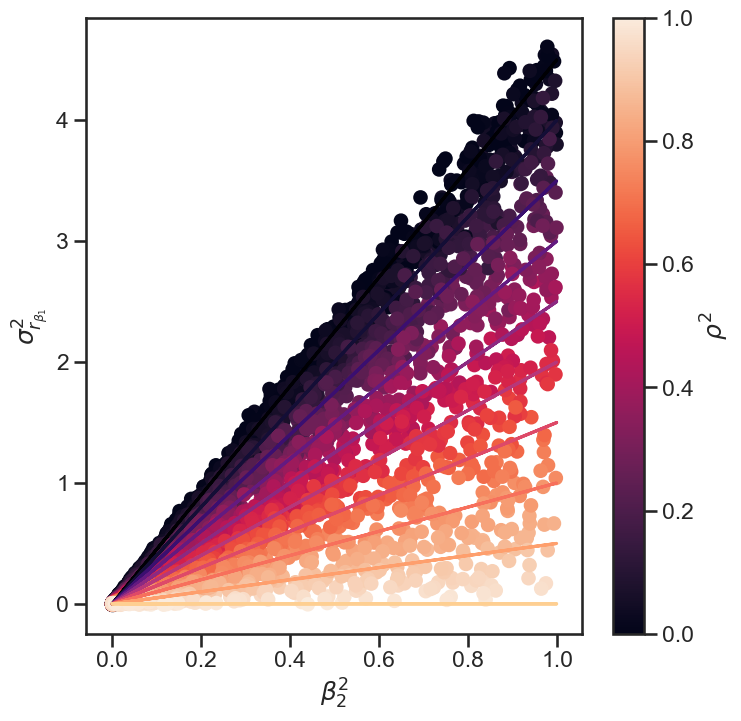

In [27]:
plt.scatter(df.b2**2, df.std_resid1**2 - sig_int**2, c=df.corr_coef**2)
plt.colorbar(label='$\\rho^2$')
for i, rho_sq in enumerate(np.linspace(0, 1, 10)):
    plt.plot(df.b2**2, df.b2**2*sig2**2*(1- rho_sq),
             color=cm.magma(i/10))
plt.xlabel('$\\beta_2^2$')
plt.ylabel('$\sigma_{r_{\\beta_1}}^2$')

We can do something similar to figure out the size of the bias on the secondary coefficient ($\Delta\beta_2 = \beta_2 - \hat{\beta_2}^\prime$).

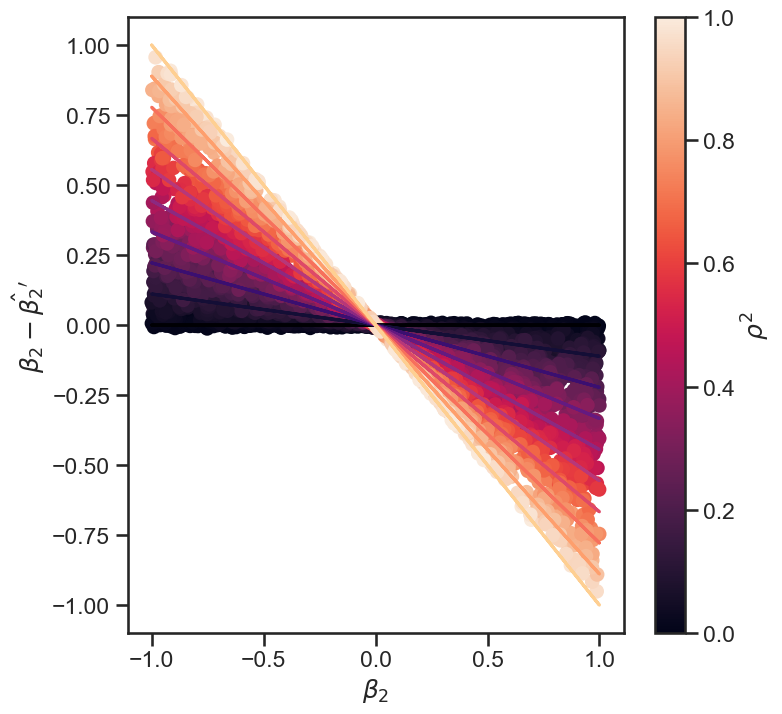

In [28]:
plt.scatter(df.b2, df.fit12_b2-df.b2, c=df.corr_coef**2)
for i, rho_sq in enumerate(np.linspace(0, 1, 10)):
    plt.plot(df.b2, -df.b2*rho_sq, color=cm.magma(i/10))
plt.xlabel('$\\beta_2$')
plt.ylabel('$\\beta_2 - \hat{\\beta_2}^\prime$')
plt.colorbar(label='$\\rho^2$')

The bias on this coefficient is $$\Delta\beta_2 = -\beta_2 \rho^2$$

The expected residuals (on $r_{\beta_1}$) are then
$$r_{\beta_2} = r_{\beta_2} - \hat{r}_{\beta_2} = -\frac{\beta_2\rho\sigma_2}{\sigma_1}x_1 + \beta_2 x_2 - \beta_2 x_2 + \beta_2\rho^2 x_2 = -\frac{\beta_2\rho\sigma_2}{\sigma_1}x_1 + \beta_2\rho^2x_2$$

Again propagating uncertainties, we find

$$\sigma_{r_\beta}^2 = \frac{\beta_2^2\rho^2\sigma_2^2}{\sigma_1^2}\sigma_1^2 + \beta_2^2\rho^4\sigma_2^2 - 2\frac{\beta_2^2\rho^3\sigma_2}{\sigma_1}\rho\sigma_1\sigma_2=\beta_2^2\rho^2\sigma_2^2+\beta_2^2\rho^4\sigma_2^2-2\beta_2^2\rho^4\sigma_2^2=\beta_2^2\rho^2\sigma_2^2\left(1-\rho^2\right)$$

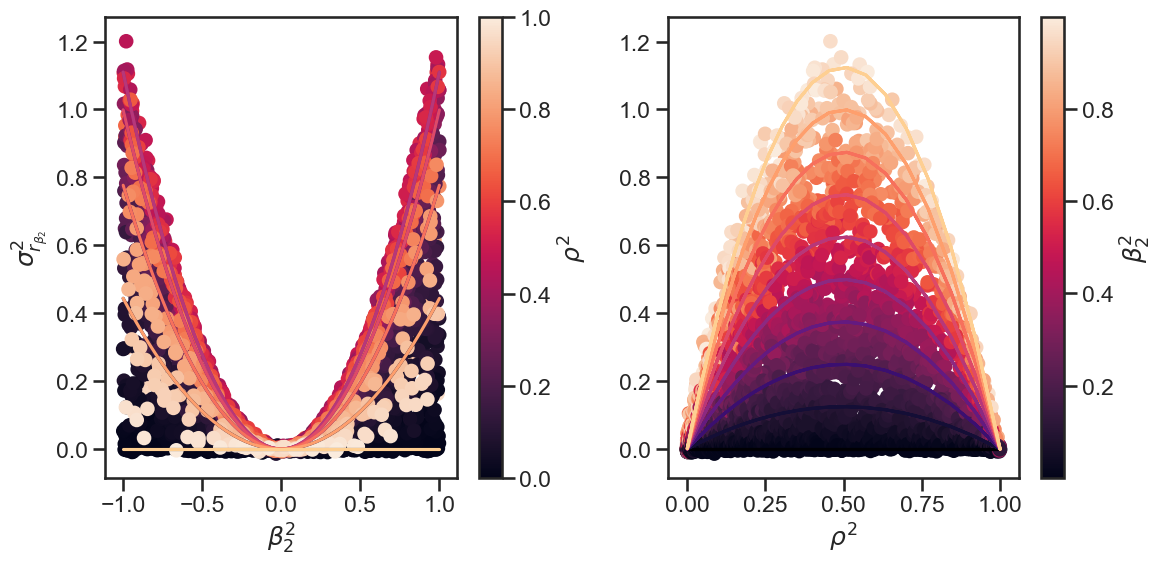

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(df.b2, df.std_resid12**2 - sig_int**2,
            c=df.corr_coef**2)
plt.colorbar(label='$\\rho^2$')
for i, rho_sq in enumerate(np.linspace(0, 1, 10)):
    linx = np.linspace(df.b2.min(), df.b2.max())
    plt.plot(linx, linx**2*rho_sq*sig2**2*(1-rho_sq),
             color=cm.magma(i/10))
plt.xlabel('$\\beta_2^2$')
plt.ylabel('$\sigma_{r_{\\beta_2}}^2$')

plt.subplot(122)
plt.scatter(df.corr_coef**2, df.std_resid12**2 - sig_int**2,
            c=df.b2**2)
plt.colorbar(label='$\\beta_2^2$')
for i, b_sq in enumerate(np.linspace((df.b2**2).min(),
                                     (df.b2**2).max(),
                                     10)):
    linx = np.linspace(-1, 1)
    plt.plot(linx**2, linx**2*b_sq*sig2**2*(1- linx**2),
             color=cm.magma(i/10))
plt.xlabel('$\\rho^2$')
plt.tight_layout()

Additionally, note that there is a linear relationship between the slope of the secondary effect (similar to the size of the host mass step) and the residuals (similar to the intrinsic scatter). 

## Adding a step function

In [30]:
a, g = 0.5, 1.
sig1 = np.sqrt(1.5)
sig2 = np.sqrt(2.)
rho = 0.5
sig_int = 0.3
n = 10000
cov = np.array([[sig1**2, rho*sig1*sig2], [rho*sig1*sig2, sig2**2]])

def generate_fake_step_data(a, g, cov, sig_int, n):
    X = np.random.multivariate_normal([0, 0], cov, n)
    epsilon = sig_int * np.random.randn(len(X))
    y = a * X[:, 0] + g/2. * np.sign(X[:, 1]) + epsilon
    return epsilon, X, y

eps, X, y = generate_fake_step_data(a, g, cov, sig_int, n)

Text(0, 0.5, '$y$')

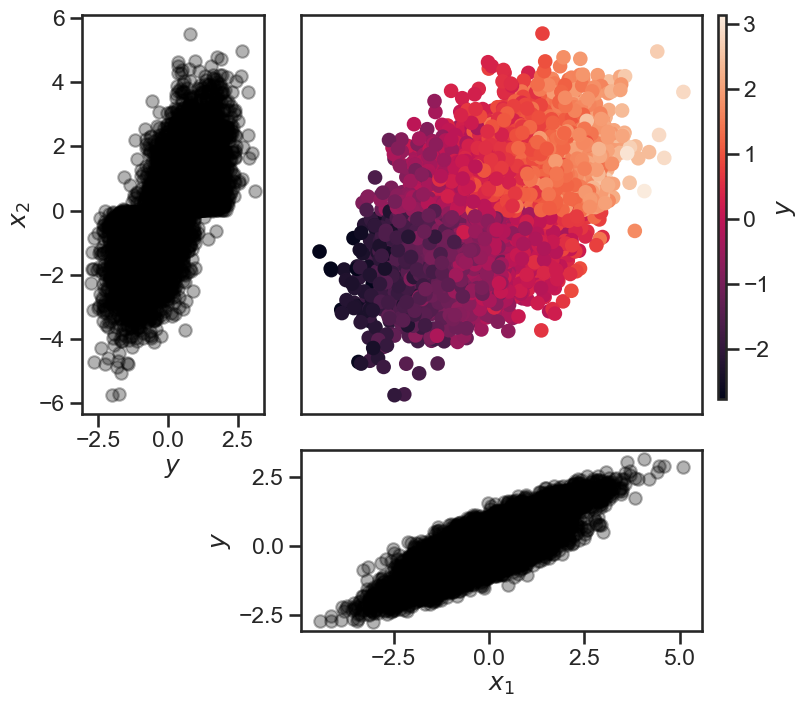

In [31]:
plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((3, 3), (0, 1), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3, 3), (0, 0), rowspan=2)
ax3 = plt.subplot2grid((3, 3), (2, 1), colspan=2)
cb_ax = plt.gcf().add_axes([0.92, 0.4, 0.01, 0.48])

scatter_x = ax1.scatter(*X.T, c=y)
cbar = plt.colorbar(scatter_x, cax=cb_ax, label='$y$')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.scatter(y, X[:, 1], color='k', alpha=0.3)
ax2.set_xlabel('$y$')
ax2.set_ylabel('$x_2$')
ax3.scatter(X[:, 0], y, color='k', alpha=0.3)
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$y$')

The simultaneous fit is slightly different now, as we're estimating 

$$y = \alpha x_1 + \frac{\gamma}{2} \text{sgn}(x_2)$$

We can estimate these values using the maximum likelihood method.

In [32]:
def fit_step_func_simultaneous(X, y):
    def neg_log_like(a0, a1, g):
        yhat = a0 + a1 * X[:, 0] + g/2. * np.sign(X[:, 1])
        return np.sum((y-yhat)**2)
    m = Minuit(neg_log_like,
               a0=0, a1=0, g=0, pedantic=False)
    m.migrad()
    return m.values['a0'], m.values['a1'], m.values['g']

In [33]:
fit_a0, fit_a1, fit_g = fit_step_func_simultaneous(X, y)
y_pred = fit_a0 + fit_a1 * X[:, 0] + fit_g/2. * np.sign(X[:, 1])

In [34]:
print('True regression coefs:     {:0.3f}, {:0.3f}, {:0.3f}'.format(0, a, g))
print('Best-fit regression coefs: {:0.3f}, {:0.3f}, {:0.3f}'.format(fit_a0, fit_a1, fit_g))

True regression coefs:     0.000, 0.500, 1.000
Best-fit regression coefs: 0.002, 0.502, 1.002


Text(0.5, 0, 'Residual')

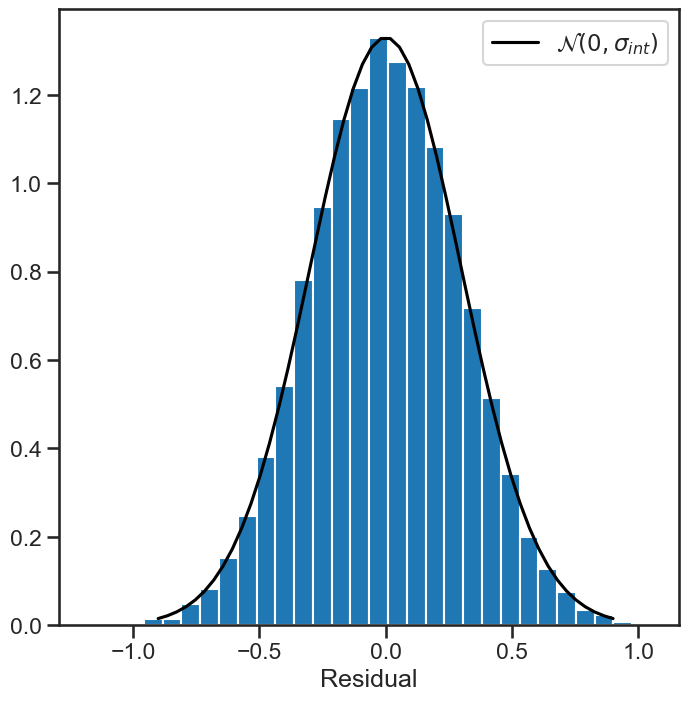

In [35]:
plt.hist(y - y_pred,
         bins=30, density=True)
linx = np.linspace(-3*sig_int, 3*sig_int)
plt.plot(linx,
         stats.norm(scale=sig_int).pdf(linx),
         color='k',
         label='$\mathcal{N}(0, \sigma_{int})$')
plt.legend()
plt.xlabel('Residual')

Let's treat things one covariate at a time again.

In [36]:
lin_a = LinearRegression()
lin_a.fit(X[:, 0].reshape(-1, 1), y)
fita_a = lin_a.coef_[0]
fita_a0 = lin_a.intercept_
r_a = y - lin_a.predict(X[:, 0].reshape(-1, 1))

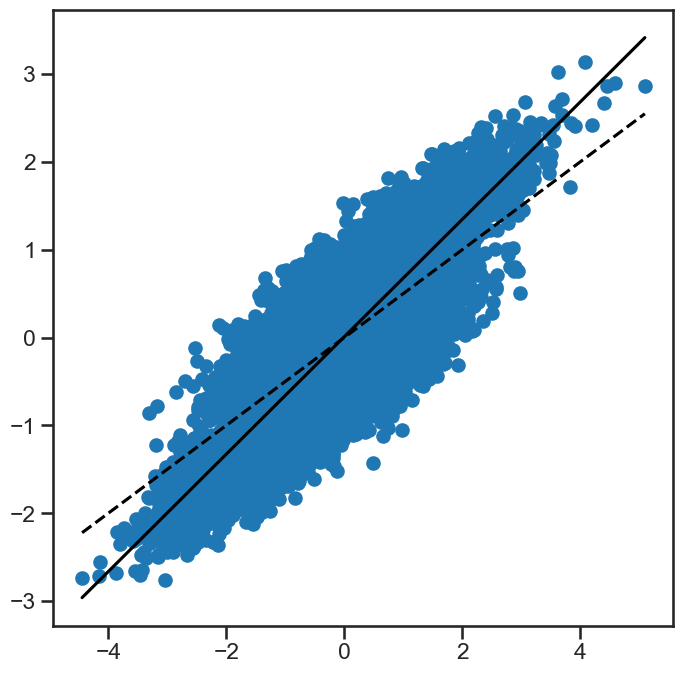

In [37]:
plt.scatter(X[:, 0], y)
linx = np.linspace(X[:, 0].min(), X[:, 0].max())
plt.plot(linx, linx * fita_a + fita_a0, color='k')
plt.plot(linx, linx * a, color='k', linestyle='--')

In [38]:
def fit_step_func(X, r_a):
    def neg_log_like(g0, g1):
        r_a_hat = g0 + g1/2. * np.sign(X)
        return np.sum((r_a-r_a_hat)**2)
    m = Minuit(neg_log_like,
               g0=0, g1=0, pedantic=False)
    m.migrad()
    return m.values['g0'], m.values['g1']

In [39]:
fitab_g0, fitab_g1 = fit_step_func(X[:, 1], r_a)
ra_pred = fitab_g0 + fitab_g1/2 * np.sign(X[:, 1])

In [40]:
print('True regression coefs:     {:0.3f}, {:0.3f}, {:0.3f}, {:0.3f}'.format(0, a, 0, g))
print('Best-fit regression coefs: {:0.3f}, {:0.3f}, {:0.3f}, {:0.3f}'.format(fita_a0, fita_a, fitab_g0,  fitab_g1))

True regression coefs:     0.000, 0.500, 0.000, 1.000
Best-fit regression coefs: 0.009, 0.668, -0.007, 0.836


Text(0.5, 0, 'Residual')

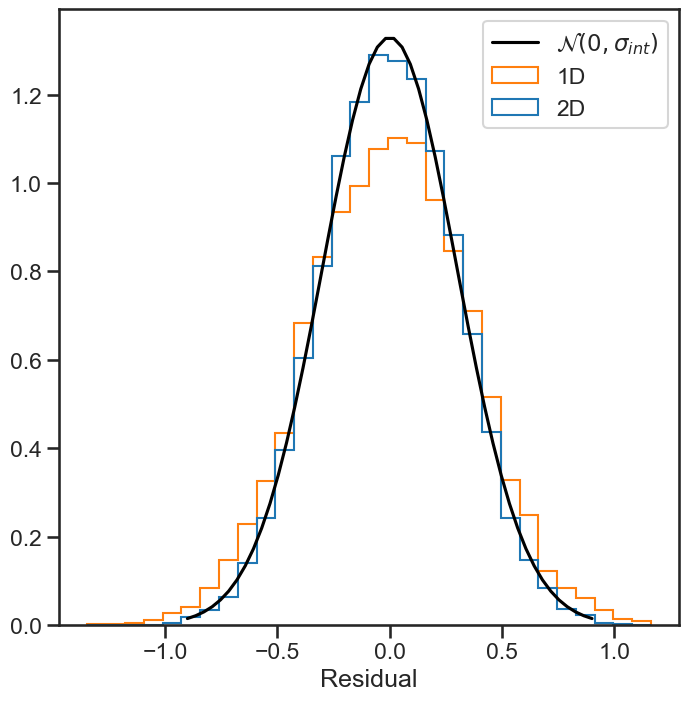

In [41]:
plt.hist([y - y_pred,
          r_a - ra_pred],
         bins=30, density=True, histtype='step',
         label=['2D', '1D'])
linx = np.linspace(-3*sig_int, 3*sig_int)
plt.plot(linx,
         stats.norm(scale=sig_int).pdf(linx),
         color='k',
         label='$\mathcal{N}(0, \sigma_{int})$')
plt.legend()
plt.xlabel('Residual')

In [42]:
np.std(y - y_pred), np.std(r_a - ra_pred)

(0.29593183587326655, 0.3496023991855085)

In [43]:
def do_step_analysis(corr, sig_int, sig1, sig2):
    def func(X):
        a, g = np.random.rand(2) * 2 - 1
        epsilon = sig_int * np.random.randn(len(X))
        y = a * X[:, 0] + g/2 * np.sign(X[:, 1]) + epsilon
        return a, g, epsilon, y
    
    cov = [[sig1**2, corr*sig1*sig2], [corr*sig1*sig2, sig2**2]]
    X = np.random.multivariate_normal([0, 0], cov, 1000)
    a, g, eps, y = func(X)
    
    fit_a0, fit_a1, fit_g = fit_step_func_simultaneous(X, y)
    y_pred = fit_a0 + fit_a1 * X[:, 0] + fit_g/2 * np.sign(X[:, 1])
    resid = y - y_pred
    coefs = [[fit_a0, fit_a1, fit_g]]
    
    lin_a = LinearRegression()
    lin_a.fit(X[:, 0].reshape(-1, 1), y)
    r_a = y - lin_a.predict(X[:, 0].reshape(-1, 1))
    coefs.append([lin_a.intercept_, lin_a.coef_[0]])

    fitab_g0, fitab_g1 = fit_step_func(X[:, 1], r_a)
    ra_pred = fitab_g0 + fitab_g1/2 * np.sign(X[:, 1])
    r_g = r_a - ra_pred
    coefs.append([fitab_g0, fitab_g1])
    
    truth = [a, g, eps]
    resids = [resid, r_a, r_g]

    return truth, coefs, resids

In [44]:
df = {}
sig1 = 0.7
sig2 = 3.
sig_int = 0.
for corr in tqdm(np.linspace(-1, 1, 4000)):
    truth, coefs, resids = do_step_analysis(corr, sig_int, sig1, sig2)
    a, g, eps = truth
    df[corr] = {'a': a,
                'g': g,
                'fit_inter': coefs[0][0],
                'fit_a': coefs[0][1],
                'fit_g': coefs[0][2],
                'fita_inter': coefs[1][0],
                'fita_a': coefs[1][1],
                'fitab_inter': coefs[2][0],
                'fitab_g': coefs[2][1],
                'std_eps': np.std(eps),
                'std_resid': np.std(resids[0]),
                'std_resida': np.std(resids[1]),
                'std_residab': np.std(resids[2])}
df = pd.DataFrame(df).T
df['corr_coef'] = df.index

100%|██████████| 4000/4000 [00:11<00:00, 361.81it/s]


In [45]:
df.head()

,a,g,fit_inter,fit_a,fit_g,fita_inter,fita_a,fitab_inter,fitab_g,std_eps,std_resid,std_resida,std_residab,corr_coef
-1.000000,0.347155,0.627463,-5.596485e-05,0.347144,0.627453,-0.001010,-0.000068,-0.002518,0.229121,0.0,4.627263e-06,0.189536,0.151017,-1.000000
-0.999500,-0.526315,0.731250,1.302088e-05,-0.526310,0.731257,-0.003779,-0.926693,0.000842,0.280588,0.0,2.384079e-06,0.226480,0.177796,-0.999500
-0.999000,-0.448215,-0.720399,5.928417e-16,-0.448215,-0.720399,0.011848,-0.033204,0.002396,-0.266410,0.0,8.598316e-16,0.219009,0.173859,-0.999000
-0.998500,0.242678,-0.393942,-1.757090e-06,0.242678,-0.393942,-0.005500,0.465895,0.001137,-0.142206,0.0,1.115631e-07,0.118328,0.094590,-0.998500
-0.997999,-0.379590,0.844460,1.562292e-14,-0.379590,0.844460,-0.007103,-0.848981,0.004022,0.309778,0.0,6.037810e-15,0.255645,0.203421,-0.997999


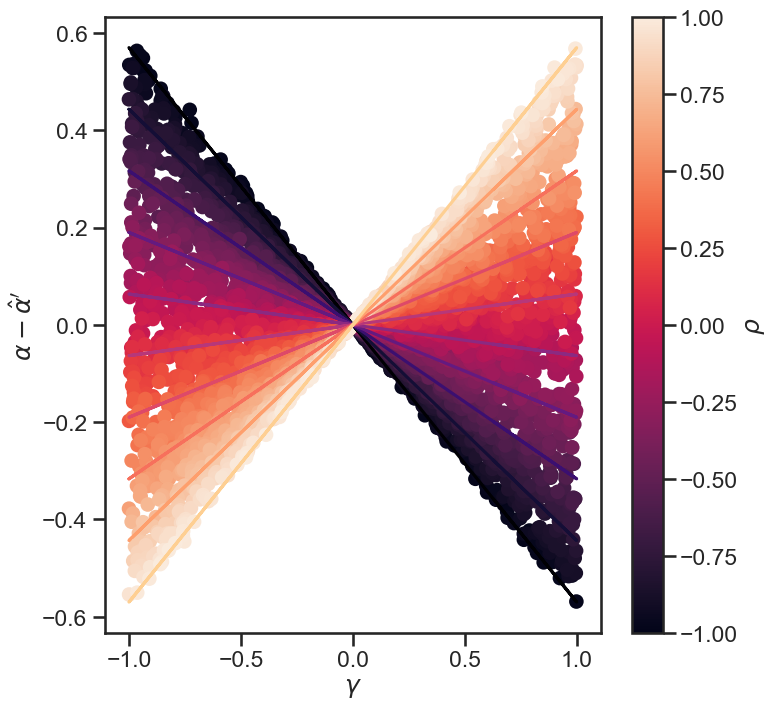

In [46]:
plt.scatter(df.g, (df.fita_a-df.a), c=df.corr_coef)
for i, corr in enumerate(np.linspace(-1, 1, 10)):
    plt.plot(df.g, df.g*corr/(sig1*np.sqrt(2*np.pi)), color=cm.magma(i/10))
plt.xlabel('$\\gamma$')
plt.ylabel('$\\alpha - \hat{\\alpha}^\prime$')
plt.colorbar(label='$\\rho$')

$$\Delta \alpha = \frac{\gamma\rho}{\sigma_1\sqrt{2\pi}}$$

The factor of $\sqrt{2\pi}$ comes from the expectation value of a slope fit to a step function.

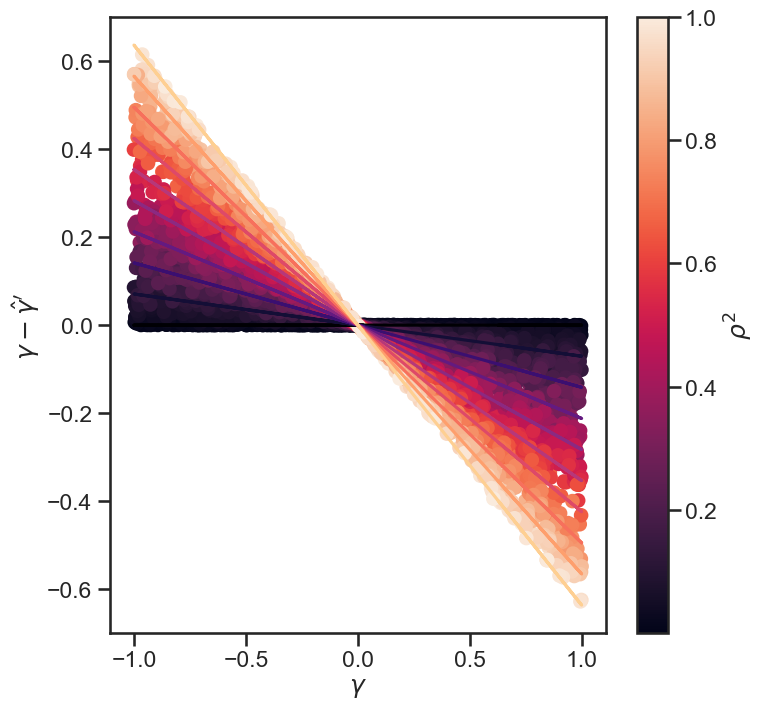

In [47]:
plt.scatter(df.g, (df.fitab_g-df.g), c=df.corr_coef**2)
for i, corr_sq in enumerate(np.linspace(0, 1, 10)):
    plt.plot(df.g, -2*df.g*corr_sq/(np.pi), color=cm.magma(i/10))
plt.xlabel('$\\gamma$')
plt.ylabel('$\\gamma - \hat{\\gamma}^\prime$')
plt.colorbar(label='$\\rho^2$')

The error on the step-size is
$$\Delta\gamma = -\frac{2\gamma\rho^2}{\pi}$$

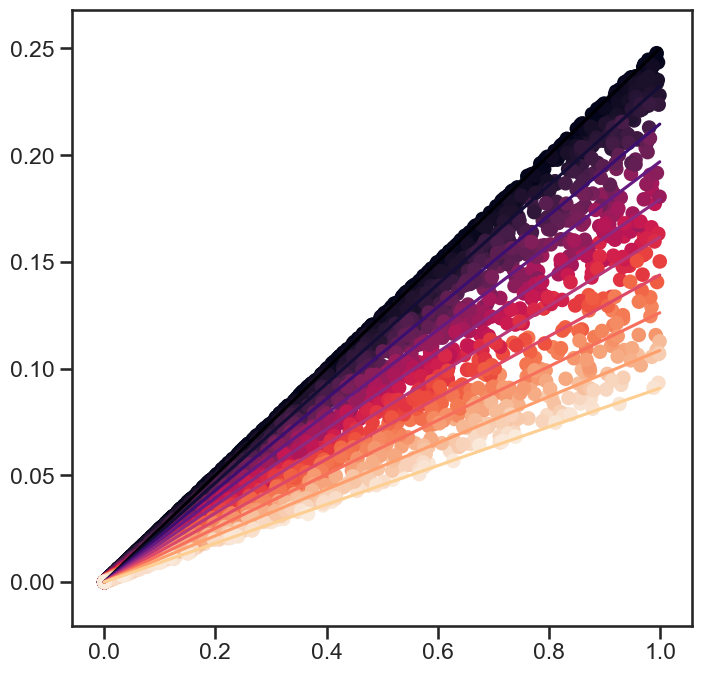

In [48]:
plt.scatter(df.g**2, df.std_resida**2 - sig_int**2, c=df.corr_coef**2)
for i, corr_sq in enumerate(np.linspace(0, 1, 10)):
    linx = np.linspace((df.g**2).min(), (df.g**2).max())
    plt.plot(linx, linx*(1/4 - corr_sq/(2*np.pi)), color=cm.magma(i/10))

$$\sigma_{r_\alpha}^2 = \gamma^2\left(\frac{1}{4} - \frac{\rho^2}{2\pi}\right)$$

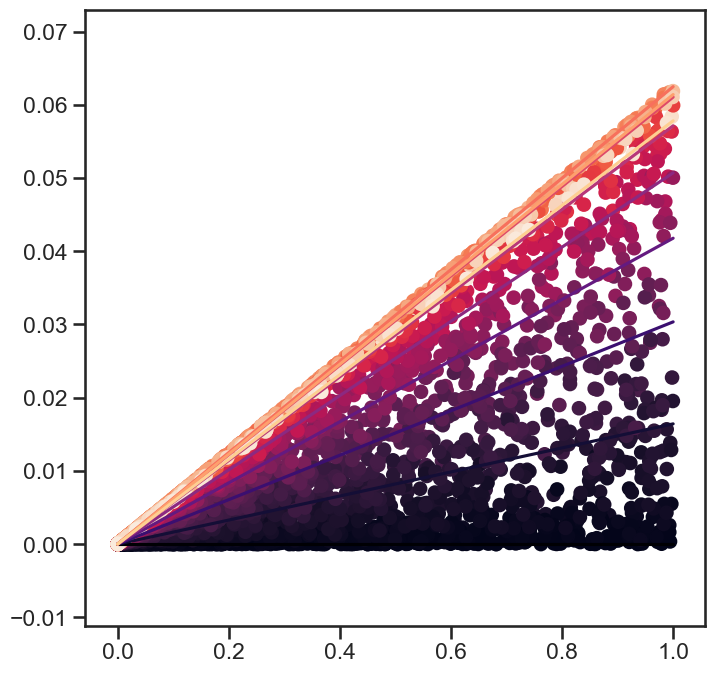

In [49]:
plt.scatter(df.g**2, df.std_residab**2 - sig_int**2, c=df.corr_coef**2)
for i, corr_sq in enumerate(np.linspace(0, 1, 10)):
    linx = np.linspace((df.g**2).min(), (df.g**2).max())
    front = linx*corr_sq/(np.pi)
    plt.plot(linx, front*(1/2 - corr_sq/(np.pi)), color=cm.magma(i/10))

$$\sigma_{r_\gamma}^2 = \frac{\gamma^2\rho^2}{\pi}\left(\frac{1}{2}-\frac{\rho^2}{\pi}\right)$$